# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [3]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

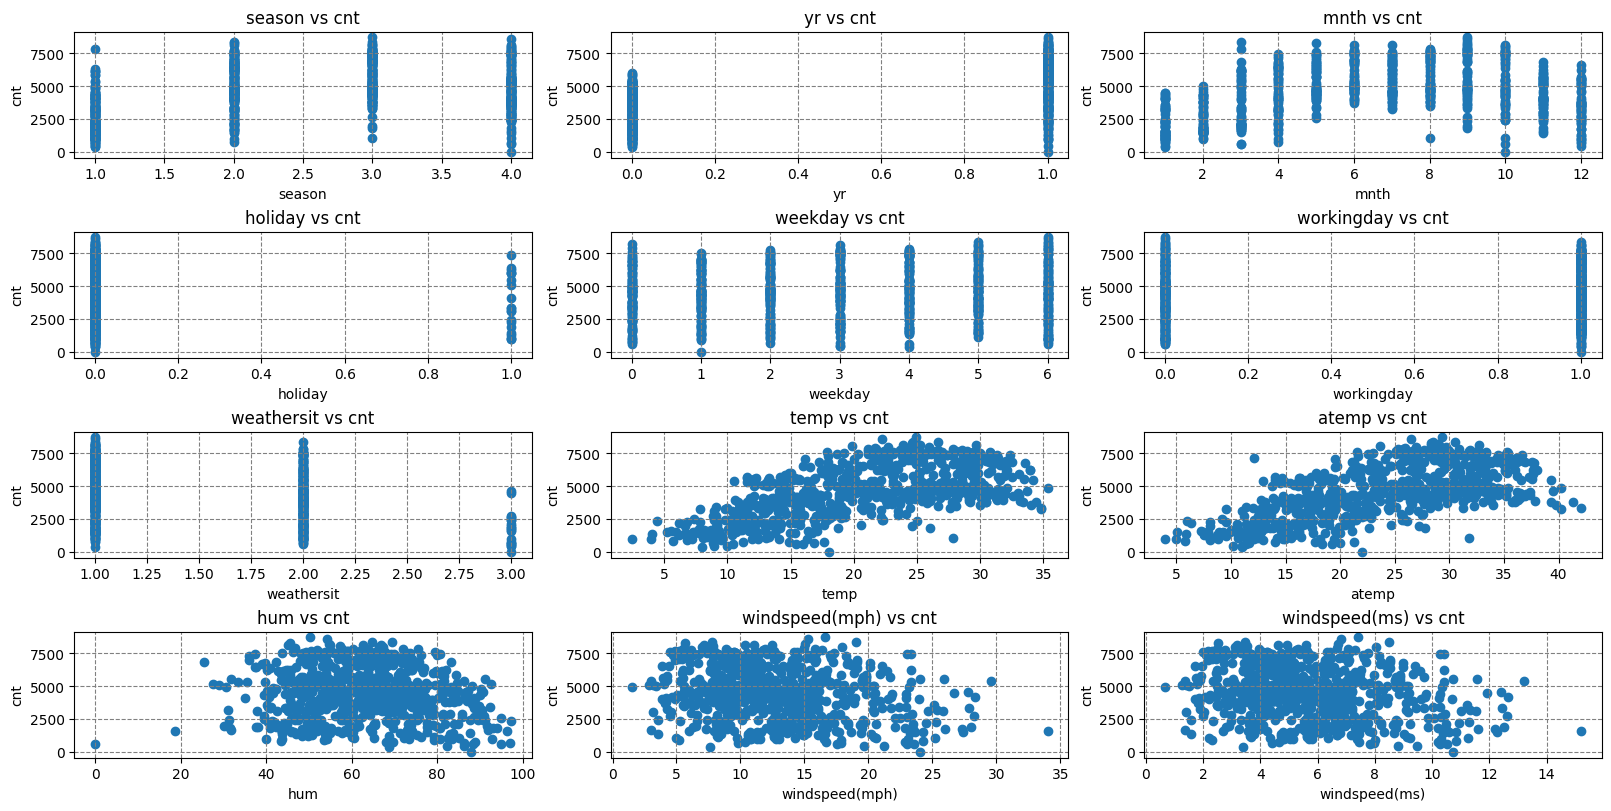

In [21]:
def plot_series(ax, df, feature, target):
    ax.scatter(df[feature], df[target])
    ax.set_title(f'{feature} vs {target}')
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
    ax.grid(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')


cols = 3
df_features = df.columns[:-1]
df_target = df.columns[-1]
fig, axs = plt.subplots(len(df_features) // cols, cols, figsize=(16, 8), layout='constrained')
for ax, feature in zip(axs.flat, df_features):
    plot_series(ax, df, feature, df_target)

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
__Відповідь:__ Можна побачити, що кількість прокатів зростає влітку і падає взимку.
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.
__Відповідь:__ Температура та температура за відчуттям.

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [28]:
for i in df.columns[:-3]:
    print(f'{i} vs {df.columns[-1]}: {df[i].corr(df[df.columns[-1]])}')

season vs cnt: 0.4061003707986361
yr vs cnt: 0.5667097078680869
mnth vs cnt: 0.27997711221927113
holiday vs cnt: -0.06834771589248417
weekday vs cnt: 0.06744341241063048
workingday vs cnt: 0.06115606306052071
weathersit vs cnt: -0.29739123883466373
temp vs cnt: 0.6274940090334922
atemp vs cnt: 0.6310656998491813
hum vs cnt: -0.10065856213715518


In [36]:
print(df[[df.columns[-2]]].corrwith(df[df.columns[-1]]))

windspeed(ms)   -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [48]:
temp_list = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
for i in temp_list[:-1]:
    print(f"Кореляція між {i} та {temp_list[temp_list.index(i) + 1]} дорівнює:")
    print(df[[i, temp_list[temp_list.index(i) + 1]]].corr())

Кореляція між temp та atemp дорівнює:
           temp     atemp
temp   1.000000  0.991702
atemp  0.991702  1.000000
Кореляція між atemp та hum дорівнює:
          atemp       hum
atemp  1.000000  0.139988
hum    0.139988  1.000000
Кореляція між hum та windspeed(mph) дорівнює:
                     hum  windspeed(mph)
hum             1.000000       -0.248489
windspeed(mph) -0.248489        1.000000
Кореляція між windspeed(mph) та windspeed(ms) дорівнює:
                windspeed(mph)  windspeed(ms)
windspeed(mph)             1.0            1.0
windspeed(ms)              1.0            1.0
Кореляція між windspeed(ms) та cnt дорівнює:
               windspeed(ms)       cnt
windspeed(ms)       1.000000 -0.234545
cnt                -0.234545  1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

## Завдання 4

Виведіть середні ознак.

In [49]:
for i in df.columns:
    print(f"Середнє значення ознаки {i} дорівнює {df[i].mean()}")

Середнє значення ознаки season дорівнює 2.496580027359781
Середнє значення ознаки yr дорівнює 0.5006839945280438
Середнє значення ознаки mnth дорівнює 6.519835841313269
Середнє значення ознаки holiday дорівнює 0.028727770177838577
Середнє значення ознаки weekday дорівнює 2.997264021887825
Середнє значення ознаки workingday дорівнює 0.6839945280437757
Середнє значення ознаки weathersit дорівнює 1.3953488372093024
Середнє значення ознаки temp дорівнює 20.31077632886457
Середнє значення ознаки atemp дорівнює 23.717699432284544
Середнє значення ознаки hum дорівнює 62.78940629274965
Середнє значення ознаки windspeed(mph) дорівнює 12.762576179069768
Середнє значення ознаки windspeed(ms) дорівнює 5.705219570438215
Середнє значення ознаки cnt дорівнює 4504.3488372093025


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [50]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [52]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [53]:
from sklearn.linear_model import LinearRegression

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [57]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
for feature, coef in zip(df.columns, linear_regressor.coef_):
    print(f"{feature}: {coef}")

season: 570.869840420185
yr: 1021.9648369366325
mnth: -141.3057498128626
holiday: -86.7602382288565
weekday: 137.22990306303458
workingday: 56.39005586999093
weathersit: -330.2330450008552
temp: 367.4652763382111
atemp: 585.5643746373447
hum: -145.6036472997277
windspeed(mph): 12460406274500.414
windspeed(ms): -12460406274698.863


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [58]:
from sklearn.linear_model import Lasso, Ridge

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
for feature, coef in zip(df.columns, lasso_regressor.coef_):
    print(f"{feature}: {coef}")

season: 560.2416160308865
yr: 1019.4634940657198
mnth: -128.73062703678733
holiday: -86.15278133371098
weekday: 137.347893904963
workingday: 55.212370641356785
weathersit: -332.3698569623486
temp: 376.36323620969347
atemp: 576.5307935045563
hum: -144.12915500348578
windspeed(mph): -197.13968940248455
windspeed(ms): -2.805103823944435e-08


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [59]:
ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
for feature, coef in zip(df.columns, ridge_regressor.coef_):
    print(f"{feature}: {coef}")

season: 563.0645722520163
yr: 1018.948378787527
mnth: -131.87332028247576
holiday: -86.74609799709245
weekday: 138.0051111787192
workingday: 55.90311037506427
weathersit: -332.3497884990726
temp: 386.45788919191114
atemp: 566.3470470600643
hum: -145.07132729867305
windspeed(mph): -99.25944108182756
windspeed(ms): -99.25944115430536


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [66]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    coefs_lasso.append(Lasso(alpha=alpha).fit(X, y).coef_)
    coefs_ridge.append(Ridge(alpha=alpha).fit(X, y).coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
coefs_lasso

array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
        -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
        -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
        -1.44129155e+02, -1.97139689e+02, -2.80510382e-08],
       [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
        -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
        -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
        -9.10689615e+01, -1.45066095e+02, -2.29895576e-08],
       [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
        -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
        -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
        -2.75042876e+01, -9.37749037e+01, -2.41636842e-08],
       [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
        -0.00000000e+00, -5.01551472e+01, -2.62778724e-08],
       [ 2.98134448e+02,  8.45652857e+02,  0.0000000

In [71]:
 coefs_ridge

array([[ 563.06457225, 1018.94837879, -131.87332028,  -86.746098  ,
         138.00511118,   55.90311038, -332.3497885 ,  386.45788919,
         566.34704706, -145.0713273 ,  -99.25944108,  -99.25944115],
       [ 461.1786324 ,  954.30774189,  -41.56545001,  -84.91347027,
         126.60366663,   54.2516911 , -313.27515141,  458.90147709,
         481.44350031, -151.29101033, -101.62731482, -101.62731483],
       [ 403.97653045,  898.08362212,    5.67424346,  -81.91106159,
         117.94141144,   52.72848389, -298.40898086,  455.28986839,
         467.43141748, -152.68605059, -102.10167084, -102.10167084],
       [ 366.60423851,  848.46346471,   34.02728278,  -78.77196479,
         110.68012006,   51.25719208, -286.12515935,  447.47982533,
         455.75402966, -151.48320603, -102.00537592, -102.00537593],
       [ 339.74528956,  804.25104797,   52.48987295,  -75.71740756,
         104.40346414,   49.84189502, -275.48609488,  438.50968939,
         444.7642744 , -148.94396978, -101.5

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

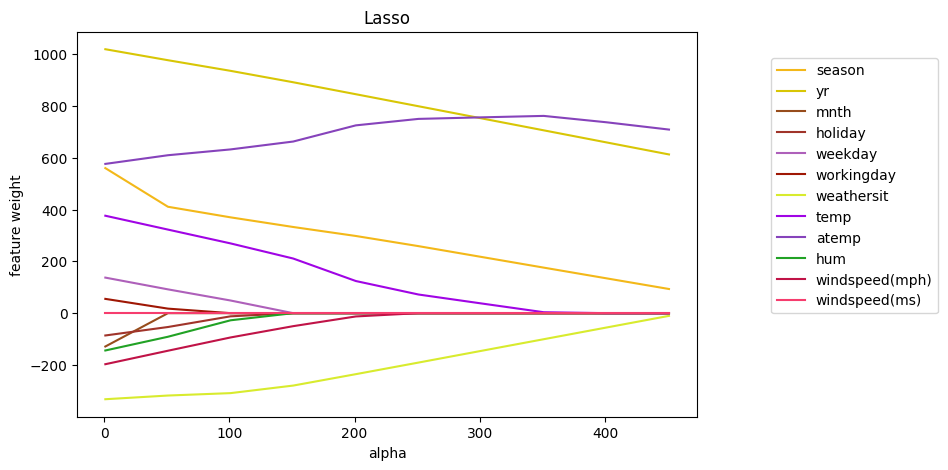

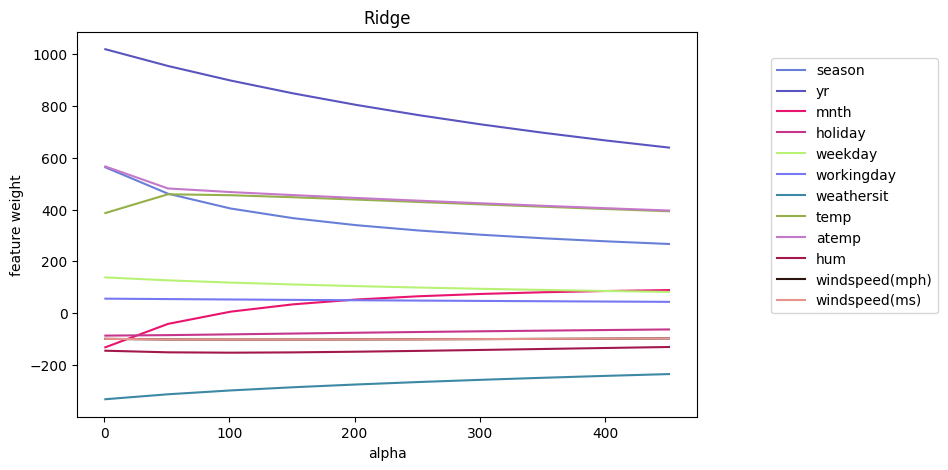

In [69]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
__Відповідь:__ Lasso

1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
__Відповідь:__ Ваги будуть зведені до нуля, оскільки L1-регуляризатор дуже сильно штрафує за великі значення ваг.

1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
__Відповідь:__ У випадку з Lasso - так, оскільки при коєфіцієнті регуляризації 1 ми бачимо -0.00000002805104. а у випадку з Ridge - ні, оскільки навіть при коєфіцієнті регуляризації 500 ми бачимо -97

1. Який із регуляризаторів підійде для відбору неінформативних ознак?
__Відповідь:__ Lasso

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [118]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Alpha = 6
season: 532.0189828413535
yr: 1015.0602226430599
mnth: -100.03952614356623
holiday: -83.29395987529915
weekday: 132.50446549095793
workingday: 51.557085614073834
weathersit: -330.5598567399815
temp: 370.6798550300334
atemp: 581.3969310654986
hum: -140.00740550068872
windspeed(mph): -191.7714084713481
windspeed(ms): -2.6856977917781423e-08


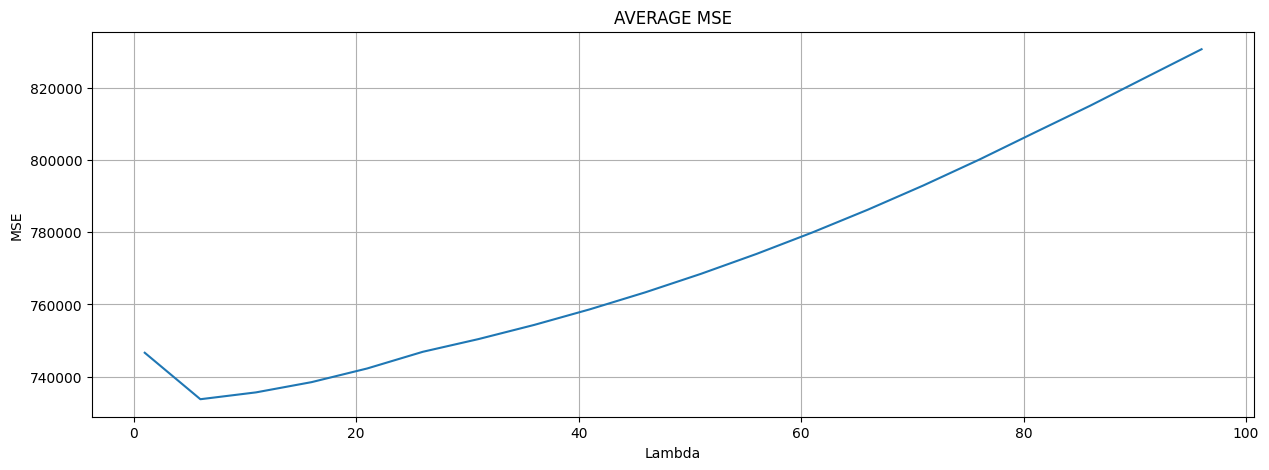

In [126]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)
print(f"Alpha = {regressor.alpha_}")
for feature, coef in zip(df.columns, regressor.coef_):
    print(f"{feature}: {coef}")
    
data = np.concatenate((regressor.alphas_.reshape(-1, 1), regressor.mse_path_), axis=1)
create_plot(data, "AVERAGE MSE", "Lambda", "MSE")

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Alpha = 6, MSE = 733725.760405224
Alpha = 1, MSE = 799433.1673691705
Alpha = 51, MSE = 796979.8955193633


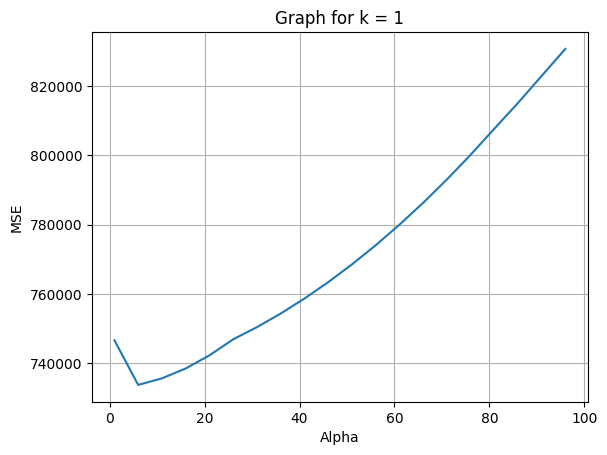

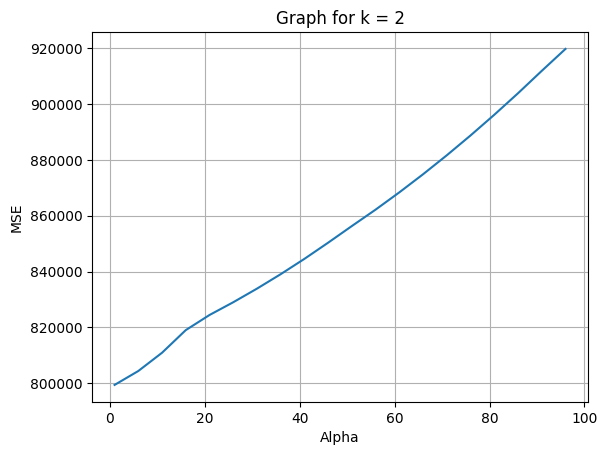

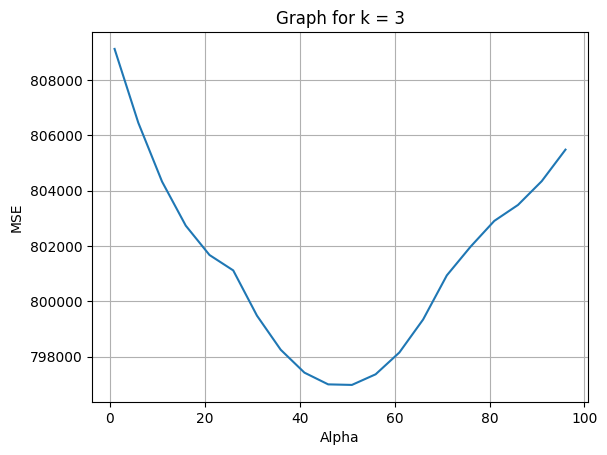

In [145]:
for i in range(3):
    print(
        f"Alpha = {regressor.alphas_[np.argmin(regressor.mse_path_[:, i])]}, MSE = {np.min(regressor.mse_path_[:, i])}")
    plt.figure()
    plt.title(f'Graph for k = {i + 1}')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.plot(data[:, 0], data[:, i + 1])

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__ 

In [146]:
# yr, atemp, season, temp
# Так, видно зростаючу лінійну залежність cnt від ознак temp, atemp. Проте у випадку з season ми бачимо, що залежність не зовсім лінійна, але вона є. Щодо yr, то тут залежність не є лінійною і важко її зрозуміти.

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [147]:
# weathersit, windspeed(mph), hum, mnth
# Так, видно зменшення лінійної залежності cnt від ознак windspeed(mph) та hum. Щодо mnth, то тут залежність не є лінійною, проте вона існує (знову ж таки як у випадку з seasons). weathersit - залежність не є лінійною, проте мінімальна вона є.

#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [148]:
# windspeed(ms) - вона колінеарна з windspeed(mph), тому модель виключила її і нам достаньо тільки одного параметру.

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.